# Add_feature 1
* 기존변수 + 추가변수 모든 조합으로 사용
* 각 mag에서 max인 filter 변수추가
* category_features 사용위해 lgb.train사용
* 제출결과 : 오히려 노이즈가 추가된 느낌

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

C:\Users\starl\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_df.head()

,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,,
0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


## DATA Setting

In [5]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [6]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [7]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
        data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [8]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

C:\Users\starl\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [9]:
def label_encode(data):
    '''
    각 mag에서 가장 높은값의 filter를 labelencoding 
    '''
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    taget_cols = ['psfMag_MAX','fiberMag_MAX','petroMag_MAX','modelMag_MAX']
    for col in taget_cols:
        data[col] = le.fit_transform(data[col])
    return data

In [10]:
train_df = label_encode(train_df)
test_df = label_encode(test_df)

In [11]:
train_X = train_df.drop(columns=['type', 'type_num'], axis=1)
train_y = train_df['type_num']
test_X = test_df

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [13]:
train_ds = lgb.Dataset(X_train, label = y_train, categorical_feature=['fiberID'])
test_ds = lgb.Dataset(X_test, label = y_test, categorical_feature=['fiberID']) 

In [14]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.005,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [15]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 20000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 1.28723	Test's multi_logloss: 1.30876
[200]	Train's multi_logloss: 0.902324	Test's multi_logloss: 0.936736
[300]	Train's multi_logloss: 0.686321	Test's multi_logloss: 0.733237
[400]	Train's multi_logloss: 0.553224	Test's multi_logloss: 0.61126
[500]	Train's multi_logloss: 0.466323	Test's multi_logloss: 0.535647
[600]	Train's multi_logloss: 0.408226	Test's multi_logloss: 0.488293
[700]	Train's multi_logloss: 0.367309	Test's multi_logloss: 0.45725
[800]	Train's multi_logloss: 0.336538	Test's multi_logloss: 0.436793
[900]	Train's multi_logloss: 0.312962	Test's multi_logloss: 0.423787
[1000]	Train's multi_logloss: 0.293692	Test's multi_logloss: 0.414907
[1100]	Train's multi_logloss: 0.277665	Test's multi_logloss: 0.408963
[1200]	Train's multi_logloss: 0.264353	Test's multi_logloss: 0.405093
[1300]	Train's multi_logloss: 0.252506	Test's multi_logloss: 0.402585
[1400]	Train's multi_logloss: 0.241998	Te

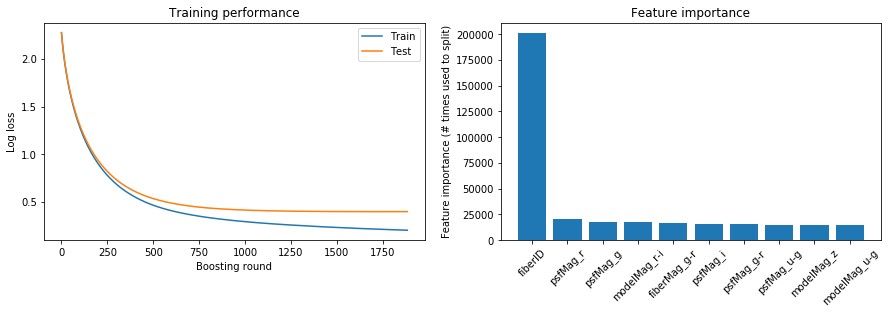

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [17]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [18]:
train_y_pred.shape

(59998, 19)

In [19]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3986205968510819

In [20]:
lgmb_model.feature_importance()

array([201010,   9102,  17495,  20711,  15970,  13304,   8873,  11726,
        14684,  12668,   8479,   9317,   8417,   9769,  10575,   9863,
         9592,  11146,   9435,   9514,  14895,    207,  15145,   8603,
         5490,   4555,  15927,   7935,   5805,  12112,   7969,  11959,
          255,  12864,   8522,   4887,   5814,  16949,   9035,   5947,
        12284,  11437,  12906,    513,  13730,   7192,   5199,   4445,
        11716,   5729,   5046,  10676,   5976,   8490,    193,  14856,
         8359,   6335,   4226,  14738,   8991,   4798,  17429,   9430,
        12737])

### feature_importance

In [21]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
fiberID,201010
psfMag_r,20711
psfMag_g,17495
modelMag_r-i,17429
fiberMag_g-r,16949
psfMag_i,15970
psfMag_g-r,15927
psfMag_u-g,15145
modelMag_z,14895
modelMag_u-g,14856


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0,2,7,11
망한예측 : 12,17

In [22]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [23]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,234,0,0,0,17,58,5,169,60,0,0,17,0,1,17,10,0,0,60
1,2,1881,0,0,0,0,1,3,13,0,3,4,0,0,0,0,6,0,39
2,0,0,71,70,0,0,0,0,0,1,8,0,0,0,0,0,0,0,0
3,0,0,32,650,0,0,1,0,0,1,85,0,0,0,0,0,0,0,0
4,1,0,0,0,4248,24,1,0,9,0,0,11,0,0,0,92,0,0,0
5,26,0,1,0,152,3628,2,77,61,0,0,4,0,0,0,84,0,0,15
6,3,23,0,0,12,1,10897,5,89,1,0,55,0,84,20,14,0,0,0
7,145,0,0,0,0,193,1,685,21,0,0,3,0,0,0,1,0,0,347
8,9,10,1,7,35,231,122,35,13089,0,12,248,0,71,74,9,15,0,936
9,0,0,0,0,0,0,0,0,8,30,0,0,0,0,0,0,0,0,0


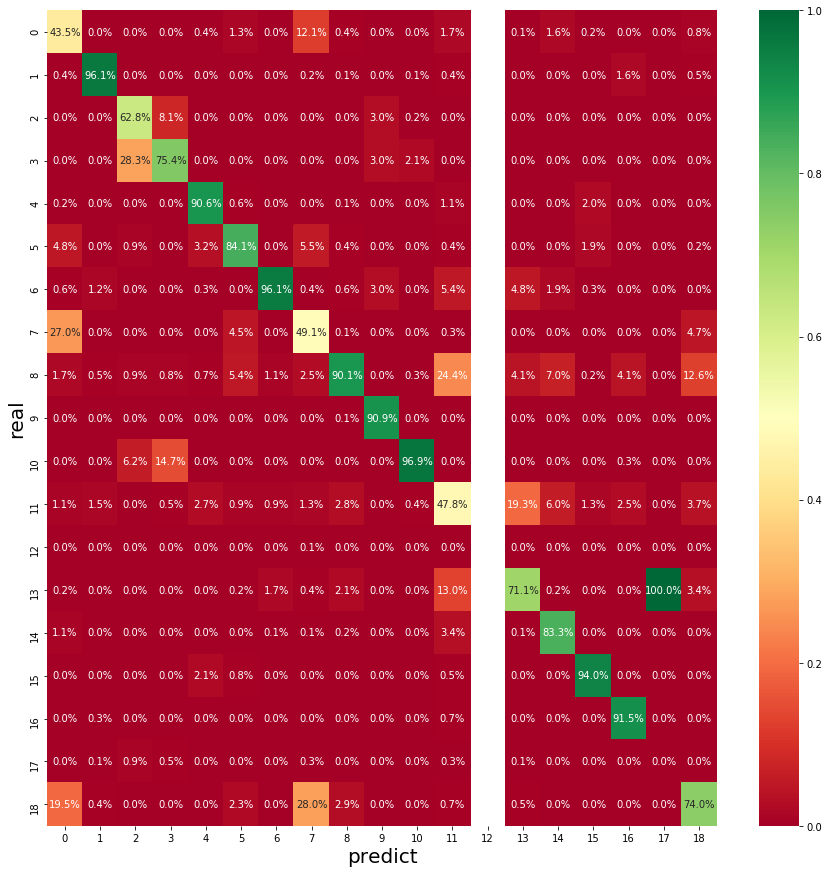

In [24]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [25]:
train_ds = lgb.Dataset(train_X, label = train_y, categorical_feature=['fiberID'])

In [26]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

C:\Users\starl\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [27]:
y_pred = lgmb_model.predict(test_X)

In [28]:
y_pred

array([[3.53545140e-05, 9.03321890e-05, 5.65347454e-05, ...,
        2.72950426e-05, 6.48077983e-06, 2.91884340e-04],
       [1.87566600e-04, 3.95066547e-04, 2.77534308e-05, ...,
        6.16387325e-05, 6.24627547e-06, 1.38925110e-03],
       [9.08740053e-05, 3.36812094e-05, 1.92700112e-06, ...,
        4.26210914e-06, 4.46250391e-07, 9.64597295e-05],
       ...,
       [1.97358609e-04, 4.40022627e-04, 2.04703239e-05, ...,
        4.52759230e-05, 4.53049812e-06, 7.84361867e-02],
       [4.52241407e-06, 8.52978246e-06, 5.59510035e-07, ...,
        1.23751502e-06, 1.26027579e-07, 2.95155142e-04],
       [4.18475320e-04, 6.93865309e-06, 4.77519820e-07, ...,
        1.05617042e-06, 1.05999950e-07, 6.25015879e-05]])

In [29]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)